# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [2]:
from pathlib import Path

data_dir = Path('D:\data\celeb_data\processed_celeba_small')

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

from torch.utils.data import DataLoader

In [4]:
def get_dataloader(batch_size, image_size, data_dir):
    """
    Batch the neural network data using DataLoader
    
    Parameter
    ---------
    batch_size : int
        The size of each batch; the number of images in a batch
    img_size : int
        The square size of the image data (x, y)
    data_dir : str, Path
        Directory where image data is located
    Returns : DataLoader
        with batched data
    """
    ## CITATION: From the Udacity Deep Learning course part of the
    ## CycleGAN exercise 
    
    # resize and normalize the images
    transform = transforms.Compose([
        transforms.Resize(image_size),
         transforms.ToTensor()
    ])

    # get training and test directories
    image_path = Path(data_dir) / 'celeba'

    # define datasets using ImageFolder
    dataset = datasets.ImageFolder(image_path, transform)

    # create and return DataLoaders
    dataloader = DataLoader(
        dataset=dataset, batch_size=batch_size,
        shuffle=True, num_workers=0
    )

    return dataloader

def test_datloader():
    data_dir = Path('D:\data\celeb_data\processed_celeba_small')
    dl = get_dataloader(2, 64, data_dir)
    btch, _ = next(iter(dl))
    assert(len(btch)==2)
    assert(isinstance(btch, torch.Tensor))
    assert(tuple(btch.shape)== (2,3,64,64))
    
test_datloader()

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size, data_dir)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

D:\ProgramData\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


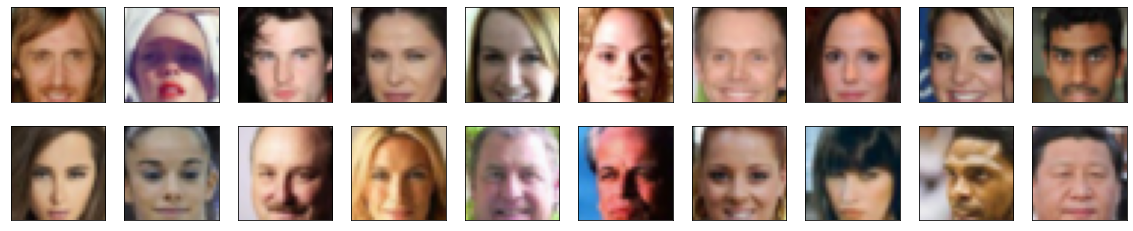

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' 
    Scale takes in an image x and returns that image, scaled
    with a feature_range of pixel values from -1 to 1. 
    This function assumes that the input x is already scaled from 0-1.
    '''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
#     x = (x+x.min())/(x.max() - x.min())  # uncomment if your units are not in a [0,1} range
    n_mx = feature_range[1]
    n_mn = feature_range[0]
    n_rng = feature_range[1] - feature_range[0]
    x = x * n_rng + n_mn
    
    return x


def test_scale():
    x = np.linspace(0, 1, num=100)
    scaled = scale(x.copy(), feature_range=(-1, 1))
    assert (int(scaled.min()) == -1)
    assert (int(scaled.max()) == 1)
    
    scaled = scale(x.copy(), feature_range=(0, 256))
    assert (int(scaled.min()) == 0)
    assert (int(scaled.max()) == 256)
    
test_scale()

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(0.7490)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# CITATION: From Udacity's Deep Learning course, CycleGAN exercise

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)
    
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
# CITATION: From Udacity's Deep Learning course, CycleGAN and DCGAN exercises

class Discriminator(nn.Module):

    def __init__(self, conv_dim, n_conv=3):
        """
        Initialize the Discriminator Module
        
        Parameters
        ----------
        conv_dim : int
            The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        # (32, 16, 8, 4)
        self.N = int(n_conv)
        self.PICDIM = 32
        self.conv_dim = conv_dim = int(conv_dim)
        for i in range(self.N):
            batch_norm = True
            if i == 0:
                in_ = 3
                out = conv_dim
                batch_norm = False
            else:
                out = conv_dim * 2**(i)
                in_ = conv_dim * 2**(i-1)
            setattr(self, f'conv{i+1}', conv(in_, out, 4, batch_norm=batch_norm))
        in_ = int(out * (self.PICDIM / (2 ** self.N))**2)
        self.FC_IN = in_
        self.fc = nn.Linear(in_, 1)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        
        Parameters
        ----------
        x : Tensor
            The input to the neural network     
            
        Returns
        -------
        Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        for i in range(self.N):
            x = F.leaky_relu(getattr(self, f'conv{i+1}')(x), 0.2)
        x = x.view(-1, self.FC_IN)
        x = self.fc(x)
        return x
    

def test_discriminator():
    myDisc = Discriminator(32)
    assert myDisc.conv1[0].out_channels == myDisc.conv2[0].in_channels
    assert myDisc.conv2[0].out_channels == myDisc.conv3[0].in_channels
    
test_discriminator()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# CITATION: From Udacity's Deep Learning course, CycleGAN exercise

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim, n_conv=3):
        """
        Initialize the Generator Module
        
        Parameters
        ----------
        z_size : int
            The length of the input latent vector, z
        conv_dim : int
            The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.N = int(n_conv)
        self.PIC_OUT = 32
        self.PIC_IN = int(self.PIC_OUT / (2 ** self.N))
        self.CONV_IN = conv_dim * 2 ** (self.N-1)
        fc_out = self.CONV_IN * self.PIC_IN**2
        self.fc = nn.Linear(z_size, fc_out)
        for i, j in enumerate(reversed(range(self.N))):
            batch_norm = True
            if j == 0:
                out = 3
                in_ = conv_dim
                batch_norm=False
            else:
                out = conv_dim * 2 **(j-1)
                in_ = conv_dim * 2 **(j)
            setattr(self, f'deconv{i+1}', deconv(in_, out, 4, batch_norm=batch_norm))

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.CONV_IN, self.PIC_IN, self.PIC_IN)
        for i in range(self.N-1):
            x = F.relu(getattr(self, f'deconv{i+1}')(x))
        x = torch.tanh(getattr(self, f'deconv{self.N}')(x))
        
        return x

def test_generator():
    myG = Generator(128, 64)
    assert myG.deconv1[0].out_channels == myG.deconv2[0].in_channels

test_generator()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    ## CITATION from junyanz CycleGAN repo: 
    # https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 128

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=128, out_features=4096, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
# CITATION: From Udacity's Deep Learning course, DCGAN exercise

def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim
# CITATION: From Udacity's Deep Learning course, DCGAN exercise

# Create optimizers for the discriminator D and generator G
# lr = 0.0002
lr = 0.0001
beta1= 0.5
beta2= 0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
# CITATION: From Udacity's Deep Learning course, DCGAN exercise

def train(D, G, n_epochs, print_every=50):
    '''
    Trains adversarial networks for some number of epochs
    
    Parameters
    ---------
    D : net
        the discriminator network
    G : net
        the generator network
    n_epochs : int
        number of epochs to train for
    print_every: int
        when to print and record the models' losses
    
    Returns
    -------
    tuple[tensor, tensor]
        D and G losses
    '''
    STEP_LR = 5

    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================

            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            # 1.1 Real Images
            if train_on_gpu:
                real_images = real_images.cuda()
            d_real = D(real_images)
            d_real_loss = real_loss(d_real)

            # 1.2 Fake Images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            d_fake = D(fake_images)

            d_fake_loss = fake_loss(d_fake)
            d_loss = d_real_loss + d_fake_loss

            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            g_fake = D(fake_images)
            g_loss = real_loss(g_fake)

            g_loss.backward()
            g_optimizer.step()


            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print(f'Batch [{batch_i:5d}] | '
                      f'Epoch [{epoch+1:5d}/{n_epochs:5d}] | '
                      f'd_loss: {d_loss.item():6.4f} | '
                      f'g_loss: {g_loss.item():6.4f}')


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [20]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs, print_every=ery=500)

Batch [    0] | Epoch [    1/   30] | d_loss: 1.9839 | g_loss: 1.1581
Batch [   50] | Epoch [    1/   30] | d_loss: 0.1689 | g_loss: 3.4382
Batch [  100] | Epoch [    1/   30] | d_loss: 0.1347 | g_loss: 4.1712
Batch [  150] | Epoch [    1/   30] | d_loss: 0.1251 | g_loss: 4.3979
Batch [  200] | Epoch [    1/   30] | d_loss: 0.1226 | g_loss: 4.4100
Batch [  250] | Epoch [    1/   30] | d_loss: 0.2749 | g_loss: 4.5086
Batch [  300] | Epoch [    1/   30] | d_loss: 0.2287 | g_loss: 3.2885
Batch [  350] | Epoch [    1/   30] | d_loss: 0.2450 | g_loss: 4.0747
Batch [  400] | Epoch [    1/   30] | d_loss: 0.3972 | g_loss: 2.9568
Batch [  450] | Epoch [    1/   30] | d_loss: 0.3279 | g_loss: 2.6107
Batch [  500] | Epoch [    1/   30] | d_loss: 0.4962 | g_loss: 2.5327
Batch [  550] | Epoch [    1/   30] | d_loss: 0.5648 | g_loss: 2.9683
Batch [  600] | Epoch [    1/   30] | d_loss: 0.3317 | g_loss: 2.4064
Batch [  650] | Epoch [    1/   30] | d_loss: 0.5828 | g_loss: 3.2466
Batch [  700] | Epoc

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

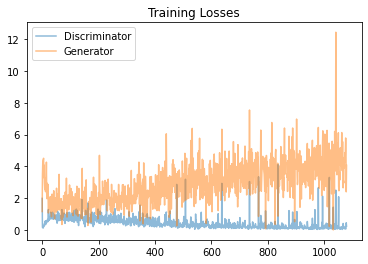

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

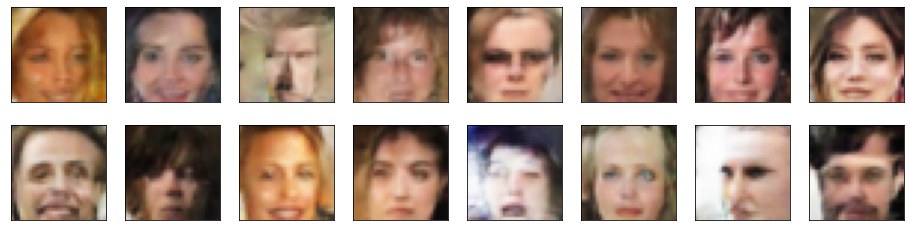

In [24]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** [ACM] I noticed the faces are quite a bit samey. Adding additional faces, increasing resolution, and increasing the epoch length may all help in increasing performance.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.